In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mat = scipy.io.loadmat('mnist-original.mat') # lecture du fichier

In [3]:
data = np.transpose(mat['data'])
label = np.transpose(mat['label'])

In [4]:
X = [] # on créé une nouvelle liste qui va contenir nos matrices 28x28
for i in range(len(data)):
    X.append(data[i].reshape(28,28))

In [5]:
def index_chiffre(n, y):  # elle nous renvoie un tableau contenant les indices représentants le chiffre n
    index = []           # j'ai rajouté le y dans les arguments car je me servirai de cette fonction dans la suite
    for i in range(len(y)):
        if y[i]==n:
            index.append(i)
    return index

In [6]:
def image_moyenne(n, X, y): # cette fonction renvoie la matrice moyenne (centroïde) pour le chiffre n
    index = index_chiffre(n, y) # de même je rajoute l'argument X et y car je m'en servirai dans la suite
    sum_matrice = np.zeros((28,28)) # la matrice qui sera utilisée dans la somme
    for i in index:
        sum_matrice += X[i] # on somme toutes les matrices représentants le chiffre n
    return sum_matrice/len(index)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = [], [], [], [] # comme la base de donnée est ordonnée, pour pouvoir diviser en train et test
for i in range(10): # on doit diviser en train test chaque set de chiffre, pour 0 pour 1 etc et on met tout dans nos matrices défeinies juste avant
    temp_x = [] # variable temporaire qui va contenir les matrices représentants le chiffre i
    temp_y = [] # variable temporaire qui va contenir les indexes représentants le chiffre i
    for j in (index_chiffre(i,label)):
        temp_x.append(X[j])
        temp_y.append(label[j])
    x_train, x_test, Y_train, Y_test = train_test_split(temp_x, temp_y, test_size=0.2) # on divise en train test pour chaque jeu de matrice représentant le chiffre i
    X_train += x_train # à chaque itération on les mets dans nos matrices précédemment définies
    X_test += x_test
    y_train += Y_train
    y_test += Y_test

In [9]:
centroide_train = []
for i in range(10): # on calcul le centroïde pour chaque chiffre i entre 0 et 9 avec X_train et y_train
    centroide_train.append(image_moyenne(i, X_train, y_train)) 

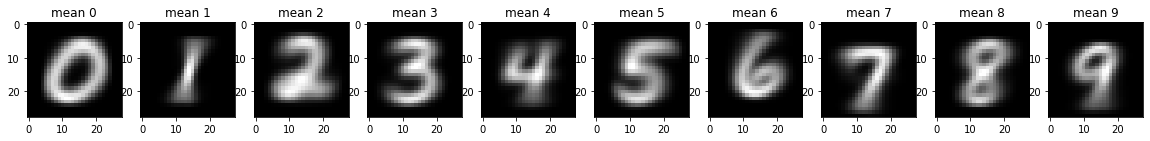

In [10]:
fig, ax = plt.subplots(1,10,figsize=(20,2)) # affichage des centroïdes 
for i in range(10):
    ax[i].imshow(centroide_train[i],cmap='gray')
    ax[i].set_title("mean "+str(i))

In [11]:
def distance(x,y,k): # fonction qui calcule la distance entre deux matrices 
    x = x.reshape(len(x)**2) # x est une matrice carré de "longueur" n donc sa représentation en vecteur sera de taille n*n
    y = y.reshape(len(y)**2)
    return np.linalg.norm(x-y,k)

##### Dans les deux prochaines lignes, on calcule le pourcentage de réussite en utilisant la norme euclidienne entre deux vecteur, pour ça on stack les lignes des matrices l'une sur l'autre pour obtenir un vecteur 784, puis on utilise la norme euclidienne entre les deux vecteurs obtenus, pour une raison que j'ignore cette méthode prend beaucoup de temps (environ 7mn pour calculer le pourcentage de réussite).

In [12]:
def prediction(x, n, k): # on va chercher le centroïde le plus proche de la matrice X_n où n est l'indice de la matrice
    minimum = distance(x[n], centroide_train[0], k) # on va chercher le minimum des distances entre X_n et chaque matrice du centroïde
    j = 0 # l'indice qui nous permettra de savoir quel case de centroide_train notre X_n représente
    for i in range(10):
        if distance(x[n], centroide_train[i], k) < minimum:
            minimum = distance(x[n], centroide_train[i], k)
            j=i # lorsqu'on a trouvé ce minimum on enregistre à quelle case il est atteint
    return float(j) # on le retourne en float pour pouvoir le comparer plus tard aux valeurs de y_test qui sont en float

In [13]:
# On va calculer le pourcentage de réussite 
j = 0 # elle va compte le nombre de fois où l'aglorithme a bien prédit
for i in range(len(X_test)):
    if y_test[i]==prediction(X_test, i, 2):
        j+=1
print("Le pourcentage de précision est :"+str(j*100/len(X_test)))

Le pourcentage de précision est :80.65552699228792


##### Ici on utilise une méthode différente pour calcule rla distance entre deux matrices, d'abord je définis la norme matricielle (celle de Frobenius), ensuite je définis la distance entre deux matrices comme étant la norme de la différence, après ça j'utilise le même code que précédemment sauf que je remplace l'ancienne distance par la nouvelle, au final cette méthode est extrêment plus rapide que la précédente (environ 4s).

In [14]:
def norme_eucli_matrice(A): # calcul de la norme euclidienne de la matrice
    return np.trace(A@(A.transpose()))**(1/2)

In [15]:
def distance_norme(x,y):
    return norme_eucli_matrice(x-y)

In [16]:
def prediction_norme(x, n): # on va chercher le centroïde le plus proche de la matrice X_n où n est l'indice de la matrice
    minimum = distance_norme(x[n], centroide_train[0]) # on va chercher le minimum des distances entre X_n et chaque matrice du centroïde
    j = 0 # l'indice qui nous permettra de savoir quel case de centroide_train notre X_n représente
    for i in range(10):
        if distance_norme(x[n], centroide_train[i]) < minimum:
            minimum = distance_norme(x[n], centroide_train[i])
            j=i # lorsqu'on a trouvé ce minimum on enregistre à quelle case il est atteint
    return float(j) # on le retourne en float pour pouvoir le comparer plus tard aux valeurs de y_test qui sont en float

In [17]:
# On va calculer le pourcentage de réussite en utilisant la norme matricielle
k = 0 # elle va compte le nombre de fois où l'aglorithme a bien prédit
for i in range(len(X_test)):
    if y_test[i]==prediction_norme(X_test, i):
        k+=1
print("Le pourcentage de précision est "+'{:.2f}'.format(k*100/len(X_test)))

Le pourcentage de précision est 80.66


##### On va maintenant utiliser plusieur norme L^p

In [18]:
def calcul_pourcentage(n): # n représente l'ordre de la norme qu'on va choisir
    k = 0
    for i in range(len(X_test)):
        if y_test[i]==prediction(X_test, i, n):
            k+=1
    return float('{:.2f}'.format(k*100/len(X_test)))

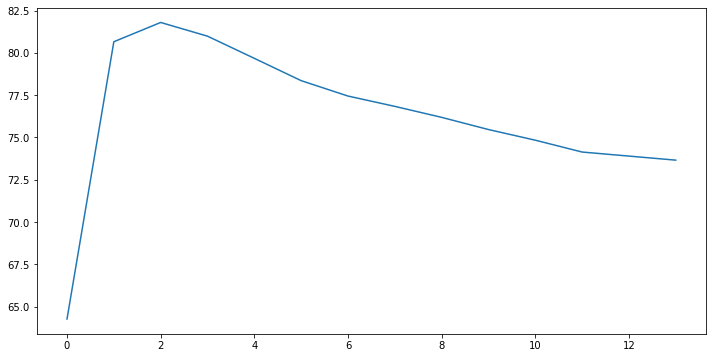

In [27]:
pourcentage = []
plt.figure(figsize=(12,6))
for i in range(1,15):
    pourcentage.append(calcul_pourcentage(i))  
plt.plot(pourcentage)


In [ ]:
# on voit que le maximum est atteint pour la troisième valeur donc on a de meilleurs résultats pour une norme L^3

In [38]:
for i in range(1,7):
    print("Le pourcentage de précision pour la norme L^"+str(i)+" est égal à "+str(pourcentage[i-1]))

Le pourcentage de précision pour la norme L^1 est égal à 64.27
Le pourcentage de précision pour la norme L^2 est égal à 80.66
Le pourcentage de précision pour la norme L^3 est égal à 81.8
Le pourcentage de précision pour la norme L^4 est égal à 80.99
Le pourcentage de précision pour la norme L^5 est égal à 79.68
Le pourcentage de précision pour la norme L^6 est égal à 78.36


##### On va utiliser un réseau de neuronnes

In [59]:
X_train = np.array(X_train) # on transforme nos données en données numpy
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [66]:
X_train = X_train / 255 # on "normalise" nos données pour avoir des valeurs comprises entre 0 et 1
X_test = X_test / 255

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [126]:
model = Sequential([
                    Flatten(input_shape=(28,28)),
                    Dense(728, activation='relu'),
                    Dense(10)
                    ])

In [127]:
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [128]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1974 - accuracy: 0.9409
Epoch 2/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0809 - accuracy: 0.9750
Epoch 3/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0505 - accuracy: 0.9837
Epoch 4/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0364 - accuracy: 0.9884
Epoch 5/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0264 - accuracy: 0.9914
Epoch 6/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0214 - accuracy: 0.9932
Epoch 7/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0162 - accuracy: 0.9948
Epoch 8/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0138 - accuracy: 0.9954
Epoch 9/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0144 - accuracy: 0.9954
Epoch 10/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.010

In [129]:
test_loss, test_acc = model.evaluate(X_test, y_test)

438/438 [==============================] - 0s 781us/step - loss: 0.0765 - accuracy: 0.9821


In [130]:
y_pred = model.predict(X_test)

In [131]:
y_pred[7643] # y_pred sort un tableau de 10 nombres qui représente la confiance du modèle que l'image correspond à chacun des 10 chiffres

array([-30.850763  , -24.697014  , -32.105778  ,   0.12890065,
       -32.54462   ,  30.405228  , -22.007614  , -28.442425  ,
        -8.011168  ,  -8.41416   ], dtype=float32)

In [132]:
model_probability = Sequential([model, Softmax()])

In [133]:
y_pred_proba = model_probability.predict(X_test)

In [143]:
y_pred_proba[12050]

array([1.8936400e-13, 3.7723877e-09, 6.8870489e-05, 1.1998316e-07,
       5.7350283e-12, 1.4836311e-08, 3.9666592e-10, 6.6447473e-12,
       9.9993098e-01, 1.1919762e-12], dtype=float32)

In [111]:
def afficher_prediction(i):
    plt.imshow(X_test[i])
    plt.title("Le numéro affiché est "+str(np.argmax(y_pred_proba[i]))+", avec un pourcentage de "+str('{:.2f}'.format(y_pred_proba[i][np.argmax(y_pred_proba[i])]*100)))
    plt.show()

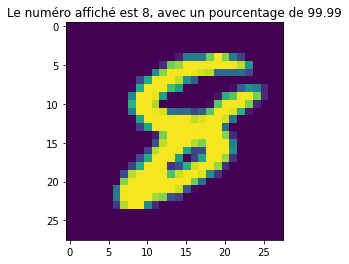

In [144]:
afficher_prediction(12050)

In [115]:
X_test[5]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    